# Node classification with Cluster-GCN

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/cluster-gcn-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/cluster-gcn-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This notebook demonstrates how to use `StellarGraph`'s implementation of *Cluster-GCN*, [1], for node classification on a homogeneous graph.

*Cluster-GCN* is a training method for scalable training of deeper Graph Neural Networks using Stochastic Gradient Descent (SGD). It is implemented as the `ClusterNodeGenerator` class ([docs](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.ClusterNodeGenerator)) in StellarGraph, which can be used with [GCN](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GCN) [2] (demonstrated here), [GAT](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GAT) and [APPNP](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.APPNP) models.

As a first step, *Cluster-GCN* splits a given graph into `k` non-overlapping subgraphs, i.e., no two subgraphs share a node. In [1], it is suggested that for best classification performance, the *METIS* graph clustering algorithm, [3], should be utilised; *METIS* groups together nodes that form a well connected neighborhood with few connections to other subgraphs. The default clustering algorithm `StellarGraph` uses is the random assignment of nodes to clusters. The user is free to use any suitable clustering algorithm to determine the clusters before training the *Cluster-GCN* model.

This notebook demonstrates how to use either random clustering or METIS. For the latter, it is necessary that 3rd party software has correctly been installed; later, we provide links to websites that host the software and provide detailed installation instructions.

During model training, each subgraph or combination of subgraphs is treated as a mini-batch for estimating the parameters of a *GCN* model. A pass over all subgraphs is considered a training epoch.

*Cluster-GCN* further extends *GCN* from the transductive to the inductive setting but this is not demonstrated in this notebook.

This notebook demonstrates *Cluster-GCN* for node classification using 2 citation network datasets, `Cora` and `PubMed-Diabetes`.

**References**

[1] Cluster-GCN: An Efficient Algorithm for Training Deep and Large Graph Convolutional Networks. W. Chiang, X. Liu, S. Si, Y. Li, S. Bengio, and C. Hsiej, KDD, 2019, arXiv:1905.07953 ([download link](https://arxiv.org/abs/1905.07953))

[2] Semi-Supervised Classification with Graph Convolutional Networks. T. Kipf, M. Welling. ICLR 2017. arXiv:1609.02907 ([download link](https://arxiv.org/abs/1609.02907))

[3] METIS: Serial Graph Partitioning and Fill-reducing Matrix Ordering. ([download link](http://glaros.dtc.umn.edu/gkhome/views/metis))

In [4]:
!pip install tensorflow==2.11.0


In [5]:
!pip install git+https://github.com/VenkateshwaranB/stellargraph.git
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

  Cloning https://github.com/VenkateshwaranB/stellargraph.git to /tmp/pip-req-build-8cpmrn31
  Running command git clone --filter=blob:none --quiet https://github.com/VenkateshwaranB/stellargraph.git /tmp/pip-req-build-8cpmrn31
  Resolved https://github.com/VenkateshwaranB/stellargraph.git to commit efa1f847109a4ba490e7a5105646a20ee09a3243
  Preparing metadata (setup.py) ... done


<div class="alert alert-block alert-danger">This notebook is designed for an older StellarGraph version 1.2.1 and may not function correctly with the newer installed version 1.3.0b. Please see: <a href="https://github.com/stellargraph/stellargraph/issues/1172">https://github.com/stellargraph/stellargraph/issues/1172</a>.</div>

<ipython-input-5-a1548499260a>:6: DeprecationWarning: This notebook is designed for an older StellarGraph version 1.2.1 and may not function correctly with the newer installed version 1.3.0b. Please see: <https://github.com/stellargraph/stellargraph/issues/1172>.
  sg.utils.validate_notebook_version("1.2.1")


In [6]:
import networkx as nx
import pandas as pd
import itertools
import json
import os

import numpy as np

from networkx.readwrite import json_graph

from sklearn.preprocessing import StandardScaler

import stellargraph as sg
from stellargraph.mapper import ClusterNodeGenerator
from stellargraph.layer import GCN
from stellargraph import globalvar

from tensorflow.keras import backend as K

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the dataset

This notebook demonstrates node classification using the *Cluster-GCN* algorithm using one of two citation networks, `Cora` and `Pubmed`.

In [7]:
display(HTML(datasets.Cora().description))
display(HTML(datasets.PubMedDiabetes().description))

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [8]:
dataset = "cora"  # can also select 'pubmed'

if dataset == "cora":
    G, labels = datasets.Cora().load()
elif dataset == "pubmed":
    G, labels = datasets.PubMedDiabetes().load()

In [9]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [10]:
set(labels)

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

We aim to train a graph-ML model that will predict the **subject** or **label** (depending on the dataset) attribute on the nodes.

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

The number of labeled nodes we use for training depends on the dataset. We use 140 labeled nodes for `Cora` and 60 for `Pubmed` training. The validation and test sets have the same sizes for both datasets. We use 500 nodes for validation and the rest for testing.

In [11]:
if dataset == "cora":
    train_size = 140
elif dataset == "pubmed":
    train_size = 60

train_labels, test_labels = model_selection.train_test_split(
    labels, train_size=train_size, test_size=None, stratify=labels
)
val_labels, test_labels = model_selection.train_test_split(
    test_labels, train_size=500, test_size=None, stratify=test_labels
)

Note using stratified sampling gives the following counts:

In [12]:
from collections import Counter

Counter(train_labels)

Counter({'Theory': 18,
         'Neural_Networks': 42,
         'Probabilistic_Methods': 22,
         'Reinforcement_Learning': 11,
         'Case_Based': 16,
         'Genetic_Algorithms': 22,
         'Rule_Learning': 9})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training.

In [13]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
val_targets = target_encoding.transform(val_labels)
test_targets = target_encoding.transform(test_labels)

Next, we prepare a Pandas DataFrame holding the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. `Cora` contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero. `Pubmed` has similar feature vectors associated with each node but the values are [tf-idf.](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

## Train using cluster GCN

### Graph Clustering

*Cluster-GCN* requires that a graph is clustered into `k` non-overlapping subgraphs. These subgraphs are used as batches to train a *GCN* model.

Any graph clustering method can be used, including random clustering that is the default clustering method in `StellarGraph`.

However, the choice of clustering algorithm can have a large impact on performance. In the *Cluster-GCN* paper, [1], it is suggested that the *METIS* algorithm is used as it produces subgraphs that are well connected with few intra-graph edges.

This demo uses random clustering by default.

#### METIS

In order to use *METIS*, you must download and install the official implementation from [here](http://glaros.dtc.umn.edu/gkhome/views/metis). Also, you must install the Python `metis` library by following the instructions [here.](https://metis.readthedocs.io/en/latest/)

In [14]:
import requests
import tarfile

# Download and extract the file
url = "http://glaros.dtc.umn.edu/gkhome/fetch/sw/metis/metis-5.1.0.tar.gz"
response = requests.get(url, stream=True)
file = tarfile.open(fileobj=response.raw, mode="r|gz")
file.extractall(path=".")

# Change working directory
%cd metis-5.1.0

# The remaining steps as you have shown in the question, with updated path
!make config shared=1 prefix=~/.local/
!make install
!cp ~/.local/lib/libmetis.so /usr/lib/libmetis.so
!export METIS_DLL=/usr/lib/libmetis.so
!pip3 install metis-python

import metispy as metis

/content/metis-5.1.0
rm -rf build/Linux-x86_64
mkdir -p build/Linux-x86_64
cd build/Linux-x86_64 && cmake /content/metis-5.1.0 -DCMAKE_VERBOSE_MAKEFILE=1 -DGKLIB_PATH=/content/metis-5.1.0/GKlib -DCMAKE_INSTALL_PREFIX=/root/.local/ -DSHARED=1
CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX comp

In [15]:
number_of_clusters = 10  # the number of clusters/subgraphs
clusters_per_batch = 2  # combine two cluster per batch
random_clusters = False  # Set to False if you want to use METIS for clustering

In [16]:
node_ids = np.array(G.nodes())

In [17]:
if random_clusters:
    # We don't have to specify the cluster because the CluserNodeGenerator will take
    # care of the random clustering for us.
    clusters = number_of_clusters
else:
    # We are going to use the METIS clustering algorith,
    print("Graph clustering using the METIS algorithm.")

    # import metis

    lil_adj = G.to_adjacency_matrix().tolil()
    adjlist = [tuple(neighbours) for neighbours in lil_adj.rows]

    edgecuts, parts = metis.part_graph(adjlist, number_of_clusters)
    parts = np.array(parts)
    clusters = []
    cluster_ids = np.unique(parts)
    for cluster_id in cluster_ids:
        mask = np.where(parts == cluster_id)
        clusters.append(node_ids[mask])

Graph clustering using the METIS algorithm.


Next we create the `ClusterNodeGenerator` object ([docs](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.ClusterNodeGenerator)) that will give us access to a generator suitable for model training, evaluation, and prediction via the Keras API.

We specify the number of clusters and the number of clusters to combine per batch, **q**.

In [18]:
generator = ClusterNodeGenerator(G, clusters=clusters, q=clusters_per_batch, lam=0.1)

Number of clusters 10
0 cluster has size 270
1 cluster has size 276
2 cluster has size 268
3 cluster has size 270
4 cluster has size 275
5 cluster has size 278
6 cluster has size 271
7 cluster has size 265
8 cluster has size 269
9 cluster has size 266


Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use two GCN layers with 32-dimensional hidden node features at each layer.
 * `activations` is a list of activations applied to each layer's output
 * `dropout=0.5` specifies a 50% dropout at each layer.

We create the `GCN` model ([docs](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GCN)) for training with *Cluster-GCN* as follows:

In [19]:
cluster_gcn = GCN(
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.5
)

To create a Keras model we now expose the input and output tensors of the *Cluster-GCN* model for node prediction, via the `GCN.in_out_tensors` method ([docs](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GCN.in_out_tensors)):

In [20]:
x_inp, x_out = cluster_gcn.in_out_tensors()

In [21]:
x_inp

[<KerasTensor: shape=(1, None, 1433) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(1, None) dtype=int32 (created by layer 'input_2')>,
 <KerasTensor: shape=(1, None, None) dtype=float32 (created by layer 'input_3')>]

In [22]:
x_out

<KerasTensor: shape=(1, None, 32) dtype=float32 (created by layer 'gather_indices')>

We are also going to add a final layer dense layer with softmax output activation. This layers performs classification so we set the number of units to equal the number of classes.

In [23]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

Finally, we build the TensorFlow model and compile it specifying the loss function, optimiser, and metrics to monitor.

In [24]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

### Train the model

We are now ready to train the `GCN` model using *Cluster-GCN*, keeping track of its loss and accuracy on the training set, and its generalisation performance on a validation set.

We need two generators, one for training and one for validation data. We can create such generators by calling the `flow` method of the `ClusterNodeGenerator` object we created earlier and specifying the node IDs and corresponding ground truth target values for each of the two datasets.

In [25]:
train_gen = generator.flow(train_labels.index, train_targets, name="train")
val_gen = generator.flow(val_labels.index, val_targets, name="val")

Finally, we are ready to train our `GCN` model by calling the `fit` method of our TensorFlow Keras model.

In [26]:
history = model.fit(
    train_gen, validation_data=val_gen, epochs=50, verbose=1, shuffle=False
)

Epoch 1/50
5/5 [==============================] - 3s 311ms/step - loss: 1.9357 - acc: 0.1357 - val_loss: 1.9230 - val_acc: 0.2620
Epoch 2/50
5/5 [==============================] - 1s 147ms/step - loss: 1.9176 - acc: 0.2286 - val_loss: 1.9038 - val_acc: 0.3200
Epoch 3/50
5/5 [==============================] - 0s 80ms/step - loss: 1.8813 - acc: 0.3429 - val_loss: 1.8857 - val_acc: 0.3400
Epoch 4/50
5/5 [==============================] - 1s 122ms/step - loss: 1.8442 - acc: 0.3714 - val_loss: 1.8559 - val_acc: 0.3380
Epoch 5/50
5/5 [==============================] - 1s 166ms/step - loss: 1.8102 - acc: 0.3500 - val_loss: 1.8261 - val_acc: 0.3260
Epoch 6/50
5/5 [==============================] - 1s 229ms/step - loss: 1.7539 - acc: 0.3429 - val_loss: 1.7890 - val_acc: 0.3200
Epoch 7/50
5/5 [==============================] - 1s 153ms/step - loss: 1.7194 - acc: 0.3500 - val_loss: 1.7465 - val_acc: 0.3100
Epoch 8/50
5/5 [==============================] - 1s 154ms/step - loss: 1.6725 - acc: 0.364

Plot the training history:

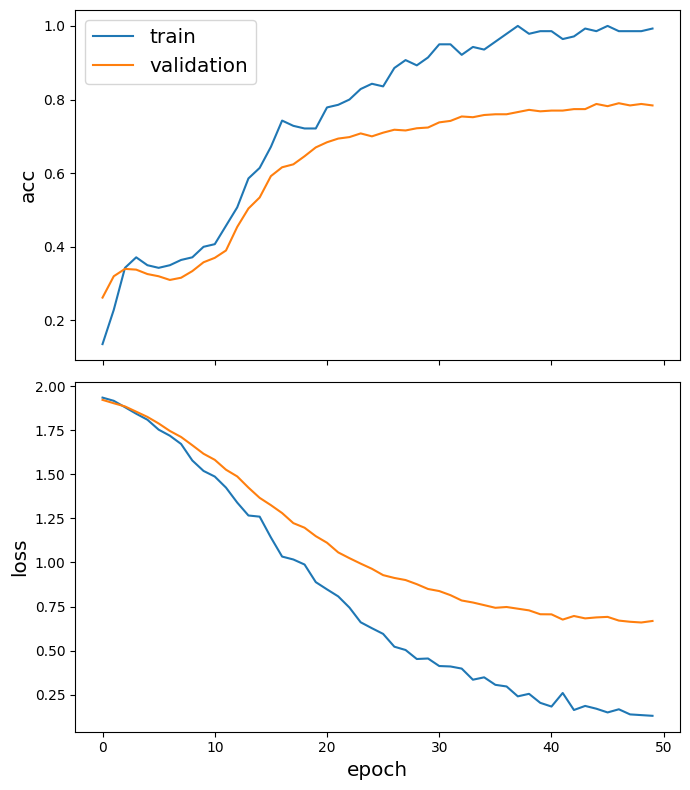

In [27]:
sg.utils.plot_history(history)

Evaluate the best model on the test set.

Note that *Cluster-GCN* performance can be very poor if using random graph clustering. Using *METIS* instead of random graph clustering produces considerably better results.

In [28]:
test_gen = generator.flow(test_labels.index, test_targets)

In [29]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

5/5 [==============================] - 0s 40ms/step - loss: 0.6701 - acc: 0.7858

Test Set Metrics:
	loss: 0.6701
	acc: 0.7858


### Making predictions with the model

For predictions to work correctly, we need to remove the extra batch dimensions necessary for the implementation of *Cluster-GCN* to work. We can easily achieve this by adding a layer after the dense predictions layer to remove this extra dimension.

In [30]:
predictions_flat = layers.Lambda(lambda x: K.squeeze(x, 0))(predictions)

In [31]:
# Notice that we have removed the first dimension
predictions, predictions_flat

(<KerasTensor: shape=(1, None, 7) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'lambda_1')>)

Now let's get the predictions for all nodes.

We need to create a new model using the same as before input Tensor and our new **predictions_flat** Tensor as the output. We are going to re-use the trained model weights.

In [32]:
model_predict = Model(inputs=x_inp, outputs=predictions_flat)

In [33]:
all_nodes = list(G.nodes())
all_gen = generator.flow(all_nodes, name="all_gen")
all_predictions = model_predict.predict(all_gen)

5/5 [==============================] - 0s 26ms/step


In [34]:
all_predictions.shape

(2708, 7)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specification to turn these values back to the original categories.

In [35]:
node_predictions = target_encoding.inverse_transform(all_predictions)

Let's have a look at a few predictions after training the model:

In [36]:
len(all_gen.node_order)

2708

In [37]:
results = pd.Series(node_predictions, index=all_gen.node_order)
df = pd.DataFrame({"Predicted": results, "True": labels})
df.head(10)

,Predicted,True
35,Genetic_Algorithms,Genetic_Algorithms
40,Genetic_Algorithms,Genetic_Algorithms
114,Reinforcement_Learning,Reinforcement_Learning
117,Reinforcement_Learning,Reinforcement_Learning
128,Reinforcement_Learning,Reinforcement_Learning
130,Reinforcement_Learning,Reinforcement_Learning
164,Theory,Theory
288,Reinforcement_Learning,Reinforcement_Learning
424,Neural_Networks,Rule_Learning
434,Theory,Reinforcement_Learning


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/cluster-gcn-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/cluster-gcn-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>